In [3]:
import pymc as pm
import pymc
import matplotlib.pyplot as plt
import functools
import itertools
import numpy as np
from math import pi, sin
import arviz as az
import pandas as pd

# Γκαουσιανές Διεργασίες (Gaussian Processes)

Η Γκουσιακή κατανομή καθορίζεται από το διάνυσμα μέσων και τον πίνακα συνδιακυμάνσεων ως εξής:
$$
\begin{bmatrix}
x_1\\
x_2\\
\end{bmatrix} \thicksim\ \mathcal{N}\Bigg(
\begin{bmatrix}
\mu_1\\
\mu_2
\end{bmatrix}, \mathbf{\Sigma}=
\begin{bmatrix}
1&\rho\sigma_1\sigma_2&\dots\\
&\ddots\\
\rho\sigma_2\sigma_1&\dots&1\\
\end{bmatrix}
\Bigg)
$$

/media/alexander-fyrogenis/Elements/Διδακτορικό/Olive Oil/notebooks/venv/lib/python3.10/site-packages/scipy/stats/_multivariate.py:681: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


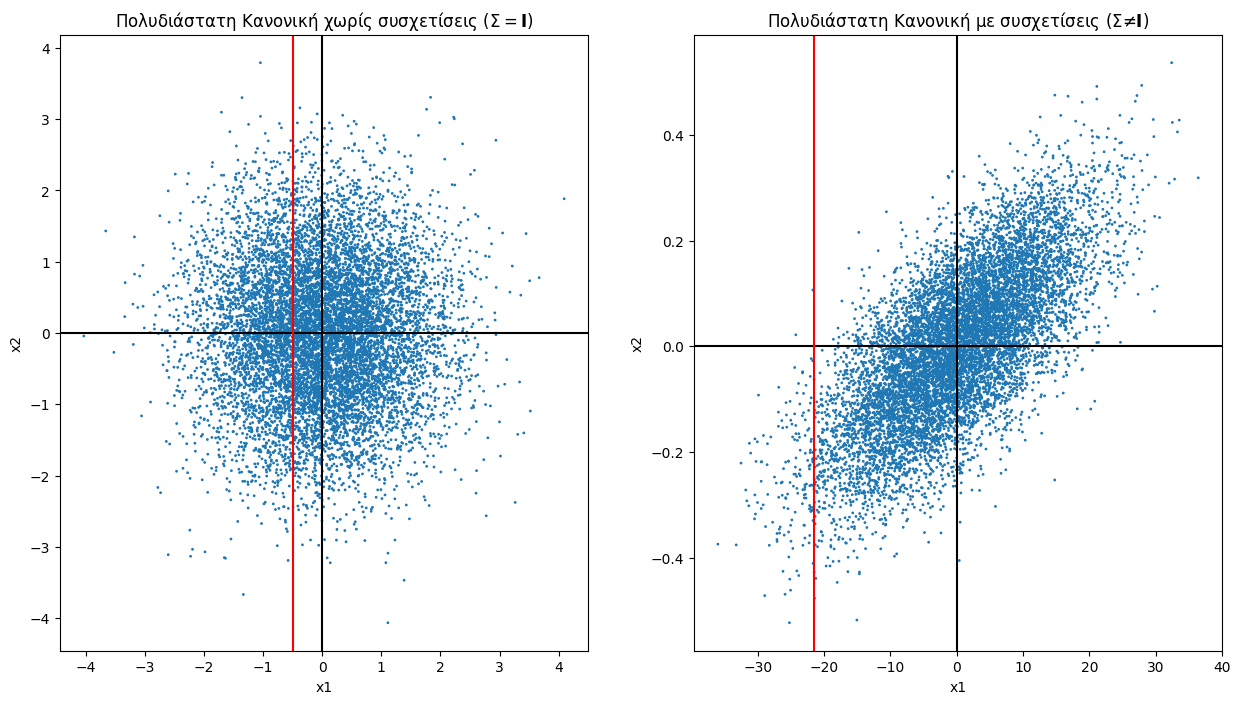

In [60]:
def gen_two_gaussians(lines:bool=True)->None:
    from random import choice
    x3 = pymc.draw(pymc.MvNormal.dist(mu=np.zeros(2), cov=1.0*np.eye(2)), 10000)
    x4 = pymc.draw(pymc.MvNormal.dist(mu=np.zeros(2), cov=np.array([[1,100.0],[0.0,1.0]])), 10000)
    fig, axs = plt.subplots(figsize=(15,8), ncols=2,nrows=1)
    axs[0].scatter(x=x3[:,0],y=x3[:,1], s=[1]*x3.shape[0])
    axs[0].axhline(0,color='black') # x = 0
    axs[0].axvline(0,color='black') # y = 0
    axs[0].set_xlabel("x1")
    axs[0].set_ylabel("x2")
    axs[0].set_title("Πολυδιάστατη Κανονική χωρίς συσχετίσεις ($\Sigma=\mathbf{I}$)")
    axs[1].scatter(x=x4[:,0],y=x4[:,1], s=[1]*x4.shape[0])
    axs[1].axhline(0,color='black') # x = 0
    axs[1].axvline(0,color='black') # y = 0
    axs[1].set_xlabel("x1")
    axs[1].set_ylabel("x2")
    _=axs[1].set_title(r"Πολυδιάστατη Κανονική με συσχετίσεις ($\Sigma\ne\mathbf{I}$)")
    if lines:
        c1,c2 = np.random.choice(x3[:,0]), np.random.choice(x4[:,0])
    axs[0].axvline(c1,color='red')
    axs[1].axvline(c2,color='red')
    plt.show()
gen_two_gaussians(lines=True)

t

In [3]:
# test  objective function
@np.vectorize
def objective(x, noise=0.1):
    noise = np.random.normal(loc=0, scale=noise)
    return (x**2 * sin(5 * pi * x)**6.0) + noise

In [4]:
X = np.arange(0,1,0.01)[:, None]

In [5]:
Y = objective(X, noise=0)
y_noisy = objective(X, noise=0.04)

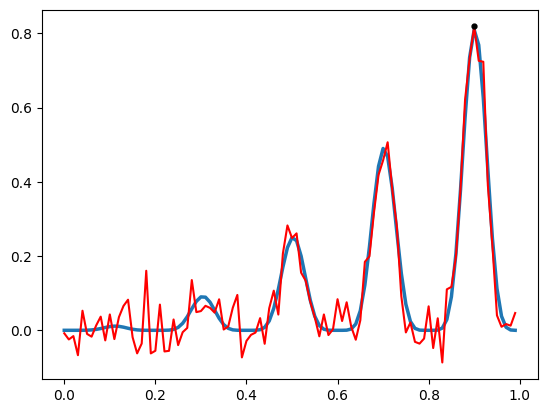

In [6]:
fig, ax = plt.subplots()
ax.plot(X,Y, linewidth=2.5)
ax.plot(X,y_noisy, color='red')
i = np.argmax(y_noisy)
ax.plot(X[i], y_noisy[i], 'k.', markersize=7)

In [131]:
with pm.Model() as model:
    λ1 = pm.HalfNormal('λ', 0.1)
    η1 = pm.Uniform('η1', 0, 1.0)
    K = η1**2*pm.gp.cov.ExpQuad(1,ls=λ1)
    gp = pm.gp.Marginal(cov_func=K)
    σ = pm.HalfNormal('σ', 5)
    y = gp.marginal_likelihood('y', X=X,y=y_noisy[:,0], sigma=σ)
    idata = pm.sample(100, tune=100, cores=2,chains=1)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [λ, η1, σ]


Sampling 1 chain for 100 tune and 100 draw iterations (100 + 100 draws total) took 12 seconds.
The acceptance probability does not match the target. It is 0.9258, but should be close to 0.8. Try to increase the number of tuning steps.


In [132]:
with model:
    Y_star = gp.conditional('Y_star', Xnew=X)
    gp_samples = pm.sample_posterior_predictive(idata,random_seed=44, var_names=['Y_star'])

Sampling: [Y_star]


In [133]:
p=gp_samples.posterior_predictive.stack(samples=['chain', 'draw'])
Ypred = p['Y_star'].values

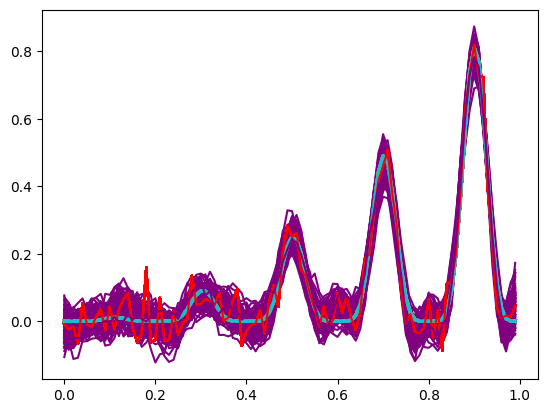

In [134]:
fig, ax = plt.subplots()
for column in range(Ypred.shape[1]):
    x = X
    y = Ypred[:,column]
    ax.plot(X,Y, linewidth=2.5)
    ax.plot(X,y_noisy, color='red')
    ax.plot(x,y, color='purple')

# With Latent

In [141]:
with pm.Model() as latent_model:
    λ1 = pm.HalfNormal('λ', 1)
    η1 = pm.Uniform('η1', 0, 1.0)
    K = η1**2*pm.gp.cov.ExpQuad(1,ls=λ1)
    gp = pm.gp.Latent(cov_func=K)
    σ = pm.HalfNormal('σ', .1)
    f = gp.prior('f', X=X)
    y = pm.Normal('y',mu=f, sigma=σ, observed=y_noisy[:,0])
    latent_idata = pm.sample(1000, tune=1000, cores=2,chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [λ, η1, σ, f_rotated_]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2209 seconds.


In [ ]:
az.plot_posterior(latent_idata)

In [143]:
latent_idata.posterior.stack(samples=['chain','draw'])['f']

<xarray.DataArray 'f' (f_dim_0: 100, samples: 2000)>
array([[ 0.01096918,  0.00618098,  0.01409323, ...,  0.04052091,
        -0.033225  , -0.02485667],
       [-0.00380189,  0.00755124, -0.03860268, ...,  0.00920531,
        -0.02010328, -0.03987676],
       [-0.02062534,  0.01056884, -0.05933019, ..., -0.00854747,
         0.00779339, -0.04343318],
       ...,
       [-0.01143235, -0.01237013, -0.04327963, ..., -0.02732849,
        -0.02856775, -0.05003245],
       [ 0.01311613, -0.00039523, -0.05730859, ..., -0.02961385,
        -0.01192206, -0.01601424],
       [ 0.02122983,  0.00485287, -0.02101988, ..., -0.00435279,
         0.02613654,  0.05473959]])
Coordinates:
  * f_dim_0  (f_dim_0) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * samples  (samples) object MultiIndex
  * chain    (samples) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
  * draw     (samples) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

In [144]:
with latent_model:
    Y_star = gp.conditional('Y_star', Xnew=X, jitter=1e-4)
    

In [145]:
with latent_model:
    latent_gp_samples = pm.sample_posterior_predictive(latent_idata, var_names=['Y_star'])

Sampling: [Y_star]


In [146]:
p=latent_gp_samples.posterior_predictive.stack(samples=['chain', 'draw'])
Ypred = p['Y_star'].values

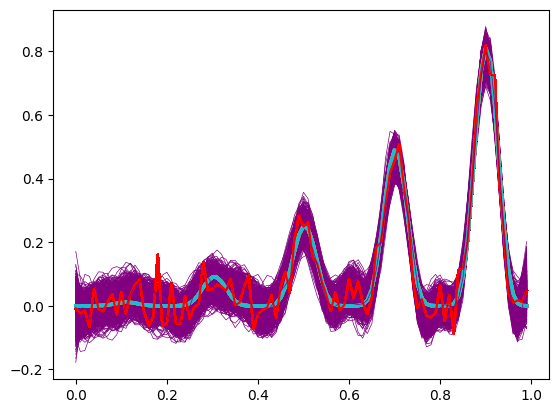

In [147]:
fig, ax = plt.subplots()
for column in range(Ypred.shape[1]):
    x = X
    y = Ypred[:,column]
    ax.plot(X,Y, linewidth=2.5)
    ax.plot(X,y_noisy, color='red')
    ax.plot(x,y, color='purple', linewidth=.5)